In [6130]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from PIL import Image
import os

In [6131]:
class ImagesDataset(Dataset):
    
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.img_names = os.listdir(root_dir)
        self.data_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor()])
        
    def __getitem__(self, index):
        img = Image.open(self.root_dir + '/' + self.img_names[index]).convert('L')
        item = self.data_transforms(img)
        img.close()
        min = item.min()
        max = item.max()
        if min != max:
            item = (item - min) / (max - min)
        return item.view(1, 64, 64)

    def __len__(self):
        return len(self.img_names)

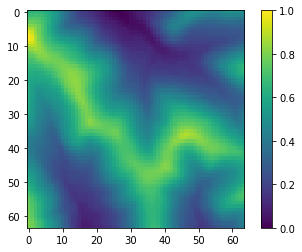

In [6132]:
import matplotlib.pyplot as plt

dataset = ImagesDataset('./data')
p = plt.imshow(dataset[6498].view(64, 64))
plt.colorbar(p)
plt.show()

In [6133]:
batch_size = 100
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7115]:
def double_cnn(in_n, out_n):
    return nn.Sequential(
        nn.Conv2d(in_n, out_n, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.Conv2d(out_n, out_n, kernel_size=3, padding=1)
    )

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder specification
        self.enc_cnn_1 = double_cnn(1, 64)
        self.enc_cnn_2 = double_cnn(64, 96)
        self.enc_cnn_3 = double_cnn(96, 128)
        self.enc_cnn_4 = double_cnn(128, 256)
        
        self.enc_linear_1_1 = nn.Linear(4096, 64)
        self.enc_linear_1_2 = nn.Linear(4096, 64)
        
        # Decoder specification
        self.dec_linear_1 = nn.Linear(64, 4096)
        
        self.dec_cnn_1 = double_cnn(256, 128)
        self.dec_cnn_2 = double_cnn(128, 96)
        self.dec_cnn_3 = double_cnn(96, 64)
        self.dec_cnn_4 = double_cnn(64, 1)
        
    def encode(self, data):
        x = self.enc_cnn_1(data)
        x = F.leaky_relu(F.max_pool2d(x, 2))

        x = self.enc_cnn_2(x)
        x = F.leaky_relu(F.max_pool2d(x, 2))

        x = self.enc_cnn_3(x)
        x = F.leaky_relu(F.max_pool2d(x, 2))

        x = self.enc_cnn_4(x)
        x = F.leaky_relu(F.max_pool2d(x, 2))

        x = x.view(x.size(0), -1)
        return self.enc_linear_1_1(x), self.enc_linear_1_2(x)
    
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
        
    def decode(self, z):
        out = F.leaky_relu(self.dec_linear_1(z))
        out = out.view(out.size(0), 256, 4, 4)
        
        out = F.interpolate(out, 8)
        out = F.leaky_relu(self.dec_cnn_1(out))
        
        out = F.interpolate(out, 16)
        out = F.leaky_relu(self.dec_cnn_2(out))
        
        out = F.interpolate(out, 32)
        out = F.leaky_relu(self.dec_cnn_3(out))
        
        out = F.interpolate(out, 64)
        out = F.leaky_relu(self.dec_cnn_4(out))
        
        return out
        
    def forward(self, data):
        mu, logvar = self.encode(data)
        z = self.reparametrize(mu, logvar)
        out = self.decode(z)
        return out, mu, logvar

In [7222]:
vae = VAE().cuda()

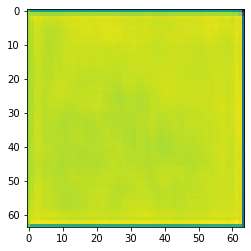

In [7223]:
x = dataset[400].cuda()
out, _, _ = vae(x.view(1, 1, 64, 64))
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

In [7224]:
import torch.optim as optim

def loss_function(recon_x, x, mu, logvar):
    MSE = nn.MSELoss(reduction='sum')(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD *= 0.1
    return MSE + KLD, MSE, KLD

optimizer = optim.Adam(vae.parameters(), lr=0.0001)

epochs = 20

for epoch in range(epochs):
    vae.train()
    i = 0
    for data in dataloader:
        i += 1
        optimizer.zero_grad()
        x = data.cuda()
        out, mu, logvar = vae(x)
        loss, MSE, KLD = loss_function(out, x, mu, logvar)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            msg = "epoch[{}/{}], loss={:.3f}, MSE={:.3f}, KLD={:.3f}".format(epoch + 1, epochs, 
                  loss.item(), MSE.item(), KLD.item())
            print(msg)

epoch[1/20], loss=40064.012, MSE=39658.855, KLD=405.158
epoch[1/20], loss=16297.068, MSE=15241.491, KLD=1055.578
epoch[1/20], loss=13316.443, MSE=12616.119, KLD=700.325
epoch[1/20], loss=11174.999, MSE=10587.636, KLD=587.363
epoch[1/20], loss=9304.027, MSE=8719.018, KLD=585.010
epoch[2/20], loss=8181.099, MSE=7573.141, KLD=607.958
epoch[2/20], loss=7544.854, MSE=6947.064, KLD=597.790
epoch[2/20], loss=7167.862, MSE=6587.590, KLD=580.273
epoch[2/20], loss=6826.305, MSE=6246.564, KLD=579.740
epoch[2/20], loss=6857.608, MSE=6261.331, KLD=596.278
epoch[3/20], loss=5486.667, MSE=4916.615, KLD=570.052
epoch[3/20], loss=5258.680, MSE=4676.579, KLD=582.101
epoch[3/20], loss=4734.655, MSE=4175.038, KLD=559.617
epoch[3/20], loss=4812.069, MSE=4216.539, KLD=595.530
epoch[3/20], loss=5409.771, MSE=4839.898, KLD=569.873
epoch[4/20], loss=4500.230, MSE=3918.772, KLD=581.458
epoch[4/20], loss=4391.247, MSE=3811.576, KLD=579.671
epoch[4/20], loss=4018.940, MSE=3436.567, KLD=582.374
epoch[4/20], loss=4

KeyboardInterrupt: 

In [7123]:
torch.cuda.empty_cache()

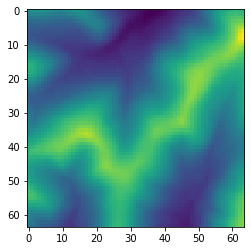

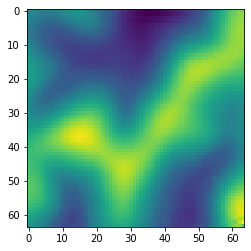

In [7248]:
x = dataset[6498].cuda()
plt.imshow(x.view(64, 64).cpu())
plt.show()
out, _, _ = vae(x.view(1, 1, 64, 64))
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

In [7215]:
#torch.save(vae.state_dict(), './vae_save')

In [7295]:
vae.load_state_dict(torch.load('./vae_save'))

<All keys matched successfully>

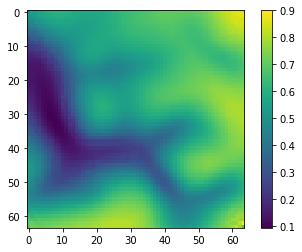

In [7316]:
# Generator
code = torch.FloatTensor(1, 64).normal_()

out = vae.decode(code.cuda())
p = plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.colorbar(p)
plt.show()